In [1]:
import function.DataFunction
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import  GridSearchCV, cross_val_score
from sklearn.svm import SVC
import function.visualise
from niapy.problems import Problem
from niapy.task import Task
from niapy.algorithms.basic import ParticleSwarmOptimization
import joblib

In [2]:
path =  'C://python//train//'
fallPath = path + 'fall_csv//'
normalPath = path + 'normal_csv//'

In [3]:
dtf = function.DataFunction.DataFunction()
vi = function.visualise.Visualise()

# Origin dataset

In [4]:
label = dtf.labelSet("origin", fallPath, normalPath)

In [5]:
label, label.shape

(array([ 1,  1,  1, ..., -1, -1, -1]), (8853,))

In [6]:
rawFallData = pd.concat([pd.read_csv(fallPath + file) for file in os.listdir(fallPath)])
rawNormalData = pd.concat([pd.read_csv(normalPath + file) for file in os.listdir(normalPath)]) 

In [7]:
data = np.concatenate((rawFallData, rawNormalData), axis=0)

In [8]:
indices = np.arange(label.shape[0])

In [9]:
np.random.shuffle(indices)

In [10]:
data, label = data[indices], label[indices]

In [11]:
data.shape, label.shape

((8853, 132), (8853,))

## Split train test validation

In [12]:
x_train, x_test, x_val, y_train, y_test, y_val = dtf.splitData(data, label)

In [13]:
x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape

((5311, 132), (1771, 132), (1771, 132), (5311,), (1771,), (1771,))

In [14]:
y_train[y_train == 1].shape, y_train[y_train == -1].shape

((1490,), (3821,))

In [15]:
y_test[y_test == 1].shape, y_test[y_test == -1].shape

((532,), (1239,))

In [16]:
y_val[y_val == 1].shape, y_val[y_val == -1].shape

((537,), (1234,))

## Make model 

In [17]:
def model_grid():
    param_grid = {'C': [0.1, 1, 10],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
    grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0)
    return grid

In [18]:
modelGrid = model_grid()

## Fit imbalanced data

### Grid search

In [19]:
modelGrid.fit(x_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']})

In [20]:
modelGrid.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

### Validation

In [21]:
def validate(x_val, y_val, model):
    scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro']
    for score in scoring:
        scores = cross_val_score(model, x_val, y_val, cv=10, scoring=score)
        print(score, scores.mean())

In [22]:
validate(x_val, y_val, modelGrid.best_estimator_)

accuracy 0.9858884022091029
precision_macro 0.9870022273337744
recall_macro 0.979914893108152
f1_macro 0.9830633429898112


### Visualise result

In [23]:
y_pred = modelGrid.predict(x_test)

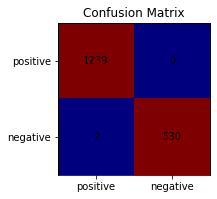

In [24]:
vi.conf_mat(y_test, y_pred)

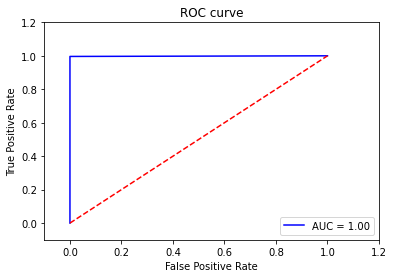

In [25]:
vi.show_roc(y_test, y_pred)

In [26]:
vi.report(y_test, y_pred)

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1239
           1       1.00      1.00      1.00       532

    accuracy                           1.00      1771
   macro avg       1.00      1.00      1.00      1771
weighted avg       1.00      1.00      1.00      1771



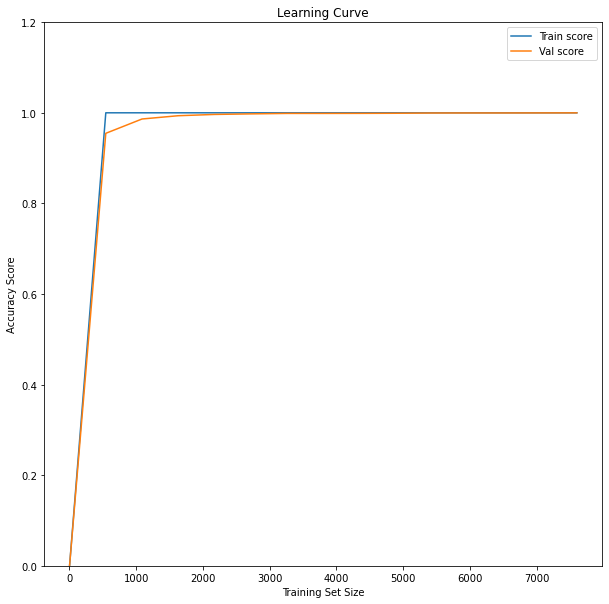

In [27]:
vi.learning_curve_plot(data, label, modelGrid.best_estimator_)

In [85]:
joblib.dump(modelGrid.best_estimator_, path + 'model_final//model_grid_1.sav')

['C://python//train//model_final//model_grid_1.sav']

## Balance data

In [29]:
x_train, y_train = dtf.balanceTrainData(x_train, y_train)

In [30]:
x_val, y_val = dtf.balanceTrainData(x_val, y_val)

In [31]:
y_train[y_train == 1].shape, y_train[y_train == -1].shape

((3821,), (3821,))

In [32]:
y_val[y_val == 1].shape, y_val[y_val == -1].shape

((1234,), (1234,))

In [33]:
modelSmote = model_grid()
modelSmote.fit(x_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']})

In [34]:
validate(x_val, y_val, modelSmote.best_estimator_)

accuracy 0.9955465587044534
precision_macro 0.9955803341950471
recall_macro 0.9955481248360872
f1_macro 0.9955463861580007


In [35]:
y_pred = modelSmote.predict(x_test)

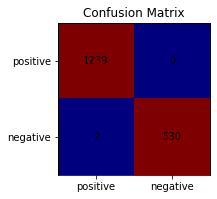

In [36]:
vi.conf_mat(y_test, y_pred)

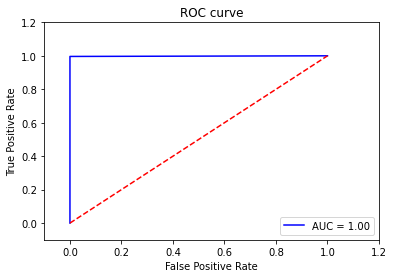

In [37]:
vi.show_roc(y_test, y_pred)

In [38]:
vi.report(y_test, y_pred)

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1239
           1       1.00      1.00      1.00       532

    accuracy                           1.00      1771
   macro avg       1.00      1.00      1.00      1771
weighted avg       1.00      1.00      1.00      1771



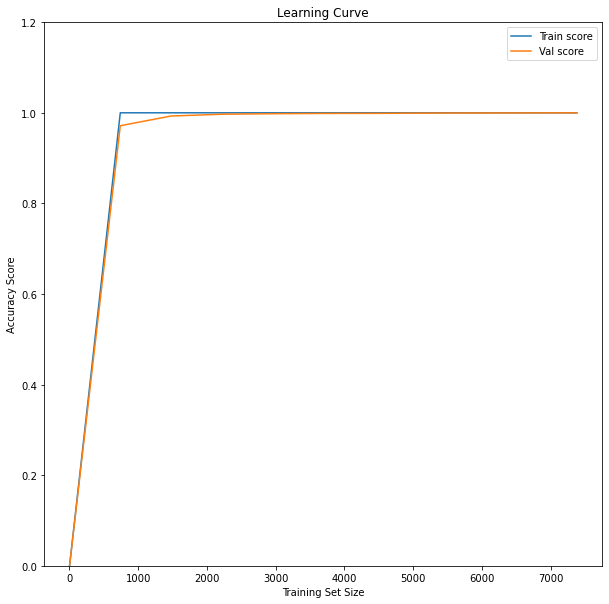

In [39]:
vi.learning_curve_plot(data, label, modelSmote.best_estimator_)

In [86]:
joblib.dump(modelSmote.best_estimator_, path + 'model_final//model_smote.sav')

['C://python//train//model_final//model_smote.sav']

# Add fall frame

In [41]:
label = dtf.labelSet(choice = "addframe", fallPath = fallPath, normalPath= normalPath)

In [42]:
label[label == 1].shape, label[label == -1].shape

((2259,), (6594,))

In [43]:
data = np.concatenate((rawFallData, rawNormalData), axis=0)

In [44]:
data.shape, label.shape

((8853, 132), (8853,))

In [45]:
indices = np.arange(label.shape[0])

In [46]:
np.random.shuffle(indices)

In [47]:
data, label = data[indices], label[indices]

In [48]:
x_train, x_test, x_val, y_train, y_test, y_val = dtf.splitData(data, label)

In [49]:
y_train[y_train == 1].shape, y_train[y_train == -1].shape

((1319,), (3992,))

## Imbalanced fit

In [50]:
modelImbalanced = model_grid()
modelImbalanced.fit(x_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']})

In [51]:
validate(x_val, y_val, modelImbalanced.best_estimator_)

accuracy 0.9802355106963752
precision_macro 0.9787030557098811
recall_macro 0.970876148799827
f1_macro 0.9742789535774256


In [52]:
y_pred = modelImbalanced.predict(x_test)

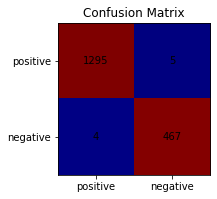

In [53]:
vi.conf_mat(y_test, y_pred)

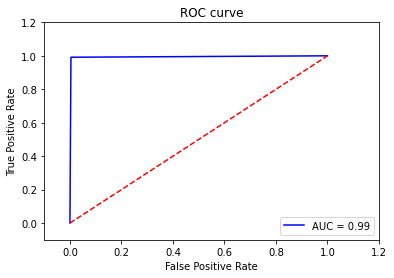

In [54]:
vi.show_roc(y_test, y_pred)

In [55]:
vi.report(y_test, y_pred)

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1300
           1       0.99      0.99      0.99       471

    accuracy                           0.99      1771
   macro avg       0.99      0.99      0.99      1771
weighted avg       0.99      0.99      0.99      1771



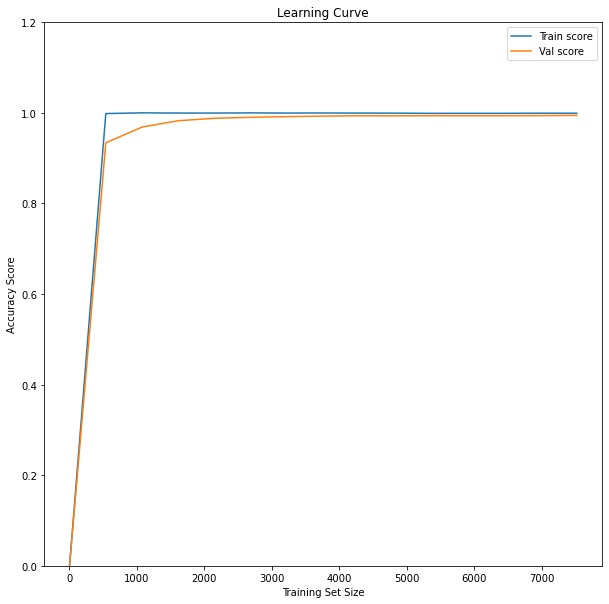

In [56]:
vi.learning_curve_plot(data, label, modelImbalanced.best_estimator_)

In [87]:
joblib.dump(modelImbalanced.best_estimator_, path + 'model_final//model_imbalanced.sav')

['C://python//train//model_final//model_imbalanced.sav']

## Balanced fit

In [58]:
x_train, y_train = dtf.balanceTrainData(x_train, y_train)
x_val, y_val = dtf.balanceTrainData(x_val, y_val)

In [59]:
y_train[y_train == 1].shape, y_train[y_train == -1].shape

((3992,), (3992,))

In [60]:
y_val[y_val == 1].shape, y_val[y_val == -1].shape

((1302,), (1302,))

In [61]:
modelBalanced = model_grid()
modelBalanced.fit(x_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']})

In [62]:
validate(x_val, y_val, modelBalanced.best_estimator_)

accuracy 0.9946242263483643
precision_macro 0.9946878553035878
recall_macro 0.9946241926012919
f1_macro 0.9946238401938737


In [63]:
y_pred = modelBalanced.predict(x_test)

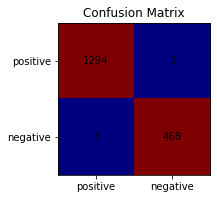

In [64]:
vi.conf_mat(y_test, y_pred)

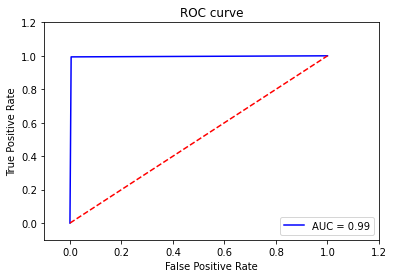

In [65]:
vi.show_roc(y_test, y_pred)

In [66]:
vi.report(y_test, y_pred)

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1300
           1       0.99      0.99      0.99       471

    accuracy                           0.99      1771
   macro avg       0.99      0.99      0.99      1771
weighted avg       0.99      0.99      0.99      1771



In [68]:
data, label = dtf.balanceTrainData(data, label)

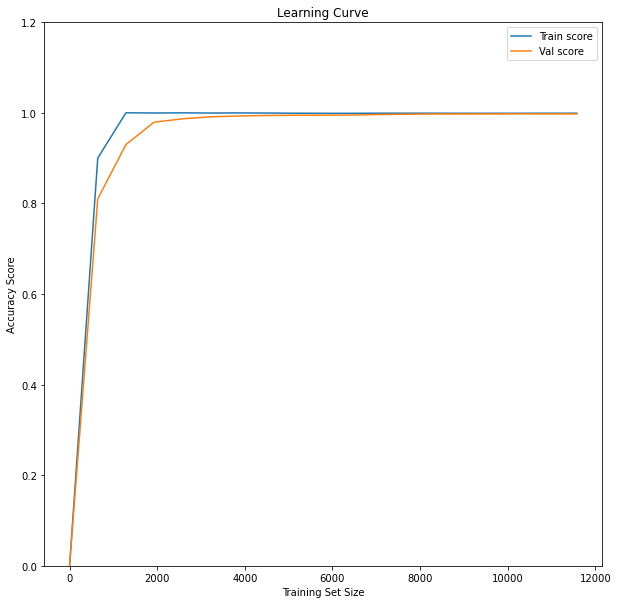

In [69]:
vi.learning_curve_plot(data, label, modelBalanced.best_estimator_)

In [88]:
joblib.dump(modelBalanced.best_estimator_, path + 'model_final//model_balanced.sav')

['C://python//train//model_final//model_balanced.sav']

## Using PSO

In [71]:
label[label == 1].shape, label[label == -1].shape

((6594,), (6594,))

In [72]:
data, label = dtf.balanceTrainData(data, label)

In [73]:
x_train, x_test, x_val, y_train, y_test, y_val = dtf.splitData(data, label)

In [74]:
class SVMFeatureSelection(Problem):
    def __init__(self, X_train, y_train, alpha=0.99):
        super().__init__(dimension=X_train.shape[1], lower=0, upper=1)
        self.X_train = X_train
        self.y_train = y_train
        self.alpha = alpha

    def _evaluate(self, x):
        selected = x > 0.5
        num_selected = selected.sum()
        if num_selected == 0:
            return 1.0
        accuracy = cross_val_score(SVC(), self.X_train[:, selected], self.y_train, cv=2, n_jobs=-1).mean()
        score = 1 - accuracy
        num_features = self.X_train.shape[1]
        return self.alpha * score + (1 - self.alpha) * (num_selected / num_features)

In [75]:
problem = SVMFeatureSelection(data, label)
task = Task(problem, max_iters=20)
algorithm = ParticleSwarmOptimization(population_size=40, group_size=20)
best_features, best_fitness = algorithm.run(task)

In [76]:
selected_features = best_features >= 0.5

In [77]:
selected_features

array([False,  True, False, False,  True,  True,  True, False, False,
       False, False, False, False,  True, False, False,  True,  True,
       False, False,  True, False, False,  True, False, False, False,
        True,  True,  True, False,  True, False,  True, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True, False, False,
       False,  True,  True, False, False,  True, False, False, False,
        True, False, False, False,  True,  True,  True, False,  True,
        True,  True, False,  True, False,  True, False,  True, False,
       False, False,  True,  True,  True, False,  True,  True, False,
        True,  True, False, False, False, False,  True,  True,  True,
       False,  True,  True, False,  True, False,  True,  True,  True,
       False, False, False, False, False,  True,  True,  True, False,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,

In [78]:
modelPSO = model_grid()
modelPSO.fit(x_train[:,selected_features], y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']})

In [79]:
validate(x_val[:,selected_features], y_val, modelPSO.best_estimator_)

accuracy 0.9920440142873602
precision_macro 0.9922226219096391
recall_macro 0.9920396715244044
f1_macro 0.9920422850518182


In [80]:
y_pred = modelPSO.predict(x_test[:,selected_features])
vi.report(y_test, y_pred)

              precision    recall  f1-score   support

          -1       1.00      0.99      1.00      1278
           1       0.99      1.00      1.00      1360

    accuracy                           1.00      2638
   macro avg       1.00      1.00      1.00      2638
weighted avg       1.00      1.00      1.00      2638



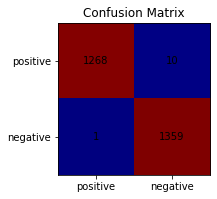

In [81]:
vi.conf_mat(y_test, y_pred)

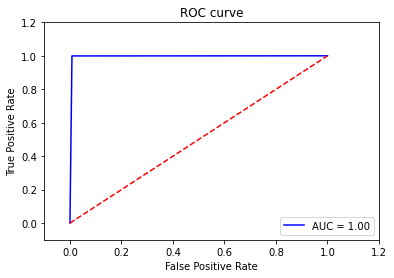

In [82]:
vi.show_roc(y_test, y_pred)

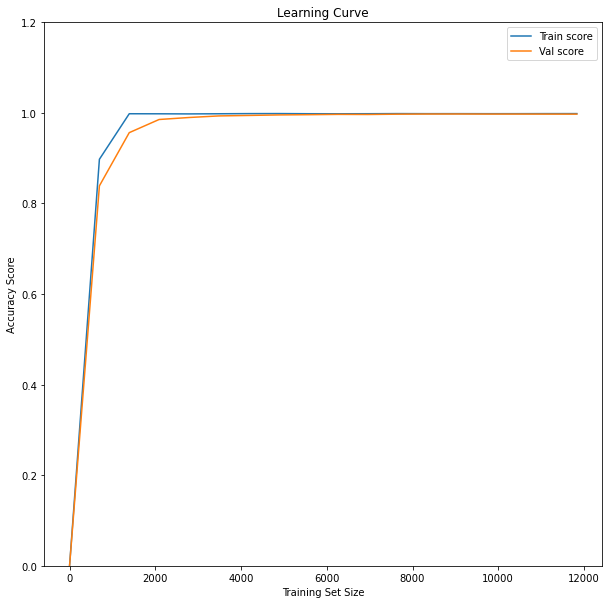

In [83]:
vi.learning_curve_plot(data[:,selected_features], label, modelPSO.best_estimator_)

In [89]:
joblib.dump(modelPSO.best_estimator_, path + 'model_final//model_pso.sav')

['C://python//train//model_final//model_pso.sav']